# Download SVHN multi digit images and pickle them.

This is copied from https://github.com/hangyao/street_view_house_numbers

In [222]:
from __future__ import print_function
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import sys
import random
import tarfile
from PIL import Image
import PIL.Image as Image
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [8]:
#Run only once if you dont have tar.gz files
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = root
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
extra_folders = maybe_extract(extra_filename)


Extracting data for train. This may take a while. Please wait.
train
Extracting data for test. This may take a while. Please wait.
test
Extracting data for extra. This may take a while. Please wait.
extra


In [193]:
train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'
extra_filename = 'extra.tar.gz'
train_folders = 'train'
test_folders = 'test'
extra_folders = 'extra'

## Extracting bounding box, label info for each file name from mat file

In [198]:
# The DigitStructFile is a wrapper around the h5py data.  
#    inf:              The input h5 matlab file
#    digitStructName   all the file names
#    digitStructBbox   all struc data

class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        #print(type(self.inf))
        self.digitStructName = self.inf['digitStruct']['name'] #shape(13068, 1), type <class 'h5py._hl.dataset.Dataset'>
        self.digitStructBbox = self.inf['digitStruct']['bbox'] #shape(13068, 1), type <class 'h5py._hl.dataset.Dataset'>
        #print('self.digitStructName.keys()==',self.digitStructName.keys())

    def getName(self,n): # returns the 'name' string for for the n(th) digitStruct. 
        #print([c for c in self.inf[self.digitStructName[n][0]].value])
        png_filename=''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])
        #print('c==',c, 'chr(c[0])==',chr(c[0]),'png_filename==',png_filename) #c== [103] #chr(c[0])== g png_filename== 1.png
        return png_filename

    def bboxHelper(self,attr): #attr=self.inf[bb]["height"]# handles the difference btw one bbox or an array of bbox. 
        #print('len(attr)==',len(attr))
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
            #print('attr.value[0]==',attr.value[0])
            #print('attr.value[0].item()==',attr.value[0].item())
            #print('self.inf[attr.value[j].item()].value==',self.inf[attr.value[j].item()].value)
        else:
            attr = [attr.value[0][0]]
            #print('attr.value[0][0]==',attr.value[0][0])
        #print('attr=',attr) #attr= [99.0, 114.0, 121.0] for left, attr= [5.0, 8.0, 6.0] for width
        return attr
 
    def getBbox(self,n):# returns a dict of data for the n(th) bbox.
        bbox = {}
        bb = self.digitStructBbox[n].item()
        #print('self.digitStructBbox[n].item()==',bb) #self.digitStructBbox[n].item()== <HDF5 object reference>
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        #print('bbox==',bbox) #bbox=={'width':[19.0],'top':[7.0],'label':[5.0],'left':[43.0],'height':[30.0]} 
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        #print('s==',s)#s== {'name':'1.png','top':[7.0],'label':[5.0],width':[19.0],'height':[30.0],'left':[43.0]}
        return s
     
    def getAllDigitStructure(self):# returns all the digitStruct from the input file.
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))] #len(self.digitStructName)
    
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure() #{'name':'1.png','top':[7.0],'label':[5.0],'width':[19.0],'height':[30.0],'left':[43.0]}
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        #print('result=',result)
        return result
    
#result= 
#[{'boxes': [{'width': 19.0, 'top': 7.0, 'label': 5.0, 'left': 43.0, 'height': 30.0}], 'filename': '1.png'}, 
# {'boxes': [{'width': 14.0, 'top': 5.0, 'label': 2.0, 'left': 99.0, 'height': 23.0}, 
#            {'width': 8.0, 'top': 8.0, 'label': 1.0, 'left': 114.0, 'height': 23.0}, 
#            {'width': 12.0, 'top': 6.0, 'label': 10.0, 'left': 121.0, 'height': 23.0}], 'filename': '2.png'}]

In [102]:
#poking
#testset
fin = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

<class 'h5py._hl.files.File'>
self.digitStructBbox[n].item()== <HDF5 object reference>
len(attr)== 1
attr= [30.0]
len(attr)== 1
attr= [5.0]
len(attr)== 1
attr= [43.0]
len(attr)== 1
attr= [7.0]
len(attr)== 1
attr= [19.0]
bbox== {'width': [19.0], 'top': [7.0], 'label': [5.0], 'left': [43.0], 'height': [30.0]}
[array([49], dtype=uint16), array([46], dtype=uint16), array([112], dtype=uint16), array([110], dtype=uint16), array([103], dtype=uint16)]
c== [103] chr(c[0])== g png_filename== 1.png
s== {'name': '1.png', 'top': [7.0], 'label': [5.0], 'width': [19.0], 'height': [30.0], 'left': [43.0]}
self.digitStructBbox[n].item()== <HDF5 object reference>
len(attr)== 3
attr= [23.0, 23.0, 23.0]
len(attr)== 3
attr= [2.0, 1.0, 10.0]
len(attr)== 3
attr= [99.0, 114.0, 121.0]
len(attr)== 3
attr= [5.0, 8.0, 6.0]
len(attr)== 3
attr= [14.0, 8.0, 12.0]
bbox== {'width': [14.0, 8.0, 12.0], 'top': [5.0, 8.0, 6.0], 'label': [2.0, 1.0, 10.0], 'left': [99.0, 114.0, 121.0], 'height': [23.0, 23.0, 23.0]}
[array([5

In [127]:
#Poking
f=h5py.File('./test/digitStruct.mat', 'r')
#print([c for c in self.inf[self.digitStructName[n][0]].value])

hdf5_arr_name=f['digitStruct']['name']
print([c for c in f[hdf5_arr_name[0][0]].value])
print([c for c in f[f['digitStruct']['name'][0][0]].value])
print([chr(c) for c in f[f['digitStruct']['name'][0][0]].value])

[array([49], dtype=uint16), array([46], dtype=uint16), array([112], dtype=uint16), array([110], dtype=uint16), array([103], dtype=uint16)]
[array([49], dtype=uint16), array([46], dtype=uint16), array([112], dtype=uint16), array([110], dtype=uint16), array([103], dtype=uint16)]
['1', '.', 'p', 'n', 'g']


In [186]:
#poking

#self.digitStructBbox = self.inf['digitStruct']['bbox']
#bb = self.digitStructBbox[n].item()
#self.bboxHelper(self.inf[bb]["height"])
#attr = [self.inf[attr.value[j].item()].value[0][0]
#attr = [attr.value[0][0]]
   
hdf5_arr_bbox = f['digitStruct']['bbox']
print(f[hdf5_arr_bbox[0][0]].keys())
print(f['digitStruct']['bbox'][0].item()) #<HDF5 object reference>

print(f[hdf5_arr_bbox[1][0]]["height"].value[0][0])
print(f[hdf5_arr_bbox[0][0]]["label"].value)
print(f[hdf5_arr_bbox[0][0]]["left"].value)
print(f[hdf5_arr_bbox[0][0]]["top"].value)
print(f[hdf5_arr_bbox[0][0]]["width"].value)


[u'height', u'label', u'left', u'top', u'width']
<HDF5 object reference>
<HDF5 object reference>
[[ 5.]]
[[ 43.]]
[[ 7.]]
[[ 19.]]


In [199]:
#testset
fin = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

In [200]:
#trainset
fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

In [201]:
#extraset
fin = os.path.join(extra_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()

## Opening each image file and save image size info

input: test_data - file name, bounding box   

output: test_imsize - images 


In [211]:
#trainset
import PIL.Image as Image
train_imsize = np.ndarray([len(train_data),2])
for i in np.arange(len(train_data)):
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    im = Image.open(fullname)
    train_imsize[i, :] = im.size[:]

In [212]:
print(np.amax(train_imsize[:,0]), np.amax(train_imsize[:,1]))
print(np.amin(train_imsize[:,0]), np.amin(train_imsize[:,1]))

876.0 501.0
25.0 12.0


In [213]:
#testset
test_imsize = np.ndarray([len(test_data),2])
for i in np.arange(len(test_data)):
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    im = Image.open(fullname)
    test_imsize[i, :] = im.size[:]

print(np.amax(test_imsize[:,0]), np.amax(test_imsize[:,1])) #image dimension in x and y
print(np.amin(test_imsize[:,0]), np.amin(test_imsize[:,1]))


1083.0 516.0
31.0 13.0


In [214]:
#extraset
extra_imsize = np.ndarray([len(extra_data),2])
for i in np.arange(len(extra_data)):
    filename = extra_data[i]['filename']
    fullname = os.path.join(extra_folders, filename)
    im = Image.open(fullname)
    extra_imsize[i, :] = im.size[:]

print(np.amax(extra_imsize[:,0]), np.amax(extra_imsize[:,1]))
print(np.amin(extra_imsize[:,0]), np.amin(extra_imsize[:,1]))

668.0 415.0
22.0 13.0


In [215]:
#Get image index that has largest and smallest dimension

print(np.where(train_imsize[:,0]==876))
print(np.where(train_imsize[:,0]==25))
print(np.where(test_imsize[:,0]==1083))
print(np.where(test_imsize[:,0]==31))
print(np.where(extra_imsize[:,0]==668))
print(np.where(extra_imsize[:,0]==22))

(array([  410,  4163, 15855, 30484]),)
(array([9747]),)
(array([ 1722,  2949,  6233, 12862]),)
(array([  459,  5352,  7776, 11257, 12191]),)
(array([ 32352,  78946, 104221, 191787, 198954]),)
(array([ 19731,  25534,  56510, 110583, 127903, 165055, 183311, 184799,
       193713, 195221]),)


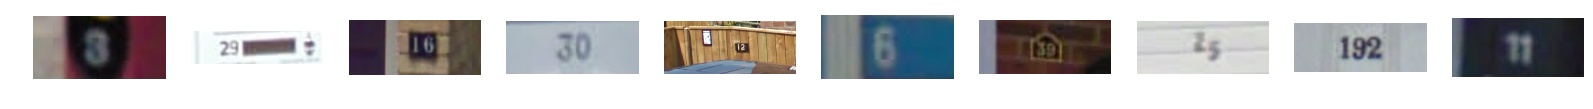

In [219]:
## Check images randomly

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []

randomNumbers=np.sort(np.random.randint(0, test_imsize.shape[0], size=10))

for i, j in enumerate(randomNumbers):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    #house_num = ''
    #for k in np.arange(test_imsize[j,0]):
        #house_num += str(test_imsize[j,k+1])
    im_samples.extend([j])
    ax[i].axis('off')
    #ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

#display.display(croped)

size= (122, 56)


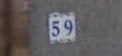

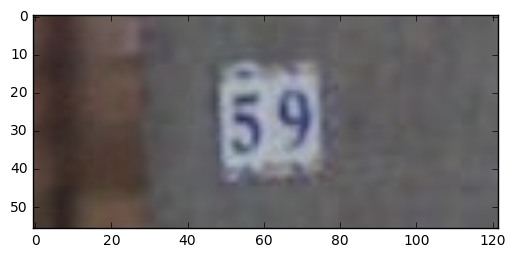

In [247]:
#poking
import PIL.Image as Image
import random
import IPython.display as display

hdf5_data = h5py.File('./test/digitStruct.mat')
name = hdf5_data['/digitStruct/name']
index= 77 #random.randint(0,1000)
file_name = ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])
img=Image.open(os.path.join('test',file_name))
print('size=',img.size)
display.display(img)
f, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(img)


In [249]:
def generate_dataset(data, folder): #input :bounding box and label , output :cropped image and label

    dataset = np.ndarray([len(data),32,32,1], dtype='float32')
    labels = np.ones([len(data),6], dtype=int) * 10
    
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes) 
        
        labels[i,0] = num_digit
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: labels[i,j+1] = 0
            else: print('#',i,'image has more than 5 digits.')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        #bounding box information 
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left
        
        # resize bounding box and create points to crop 
        im_top = np.floor(im_top - 0.1 * im_height)
        im_left = np.floor(im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])
        
        #crop, make grey scale
        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        dataset[i,:,:,:] = im[:,:,:]

    return dataset, labels



In [230]:
test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)

(13068, 32, 32, 1) (13068, 6)


size= (32, 32)


None

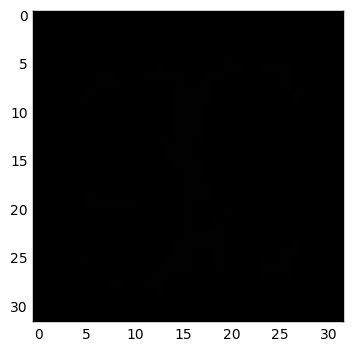

In [255]:
%matplotlib inline
index= 77 #random.randint(0,1000)
#file_name = ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])
cropped_greyed_img=Image.fromarray(test_dataset[index,:,:,:].reshape([32,32]))

print('size=',cropped_greyed_img.size)
img1=cropped_greyed_img.show()
display.display(img1)
f, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(cropped_greyed_img)

In [250]:
train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)

test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)

extra_dataset, extra_labels = generate_dataset(extra_data, extra_folders)
print(extra_dataset.shape, extra_labels.shape)

# 29929 image has more than 5 digits.
(33402, 32, 32, 1) (33402, 6)
(13068, 32, 32, 1) (13068, 6)
(202353, 32, 32, 1) (202353, 6)


In [251]:
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

In [252]:
print(train_dataset.shape, train_labels.shape)

(33401, 32, 32, 1) (33401, 6)


In [253]:
import random

random.seed()

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,1] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,1] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,1] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,1] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_dataset = np.concatenate((extra_dataset[valid_index2,:,:,:], train_dataset[valid_index,:,:,:]), axis=0)
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)
train_dataset_t = np.concatenate((extra_dataset[train_index2,:,:,:], train_dataset[train_index,:,:,:]), axis=0)
train_labels_t = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)

print(train_dataset_t.shape, train_labels_t.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(230070, 32, 32, 1) (230070, 6)
(13068, 32, 32, 1) (13068, 6)
(5684, 32, 32, 1) (5684, 6)


In [254]:
pickle_file = 'SVHN_multi.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_t,
    'train_labels': train_labels_t,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1031118824
